# Cosmic-ray flux vs. sky position

In [1]:
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.array as da
import pyunfold

import comptools as comp
color_dict = comp.color_dict

%matplotlib inline

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [3]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [4]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
#                                           energy_reco=True,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

[########################################] | 100% Completed |  6.2s


In [5]:
feature_list, feature_labels = comp.get_training_features()

In [6]:
print('Running energy reconstruction...')
energy_pipeline = comp.load_trained_model('RF_energy_{}'.format(config))
for df in [df_sim_train, df_sim_test]:
    X = df_sim_train[feature_list].values
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [7]:
# Load fitted efficiencies and calculate effective areas
# eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
#                         'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
eff_path = comp.get_efficiencies_file(config=config,
                                      num_groups=num_groups,
                                      sigmoid='slant')
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007118,0.000082,0.000083,0.006394,0.000082,0.000082,0.006734,0.000061,0.000057
1,0.007923,0.000069,0.000072,0.007471,0.000062,0.000063,0.007682,0.000049,0.000049
2,0.008372,0.000066,0.000060,0.008010,0.000065,0.000057,0.008192,0.000047,0.000045
3,0.008605,0.000068,0.000062,0.008274,0.000067,0.000061,0.008455,0.000047,0.000048
4,0.008733,0.000069,0.000061,0.008422,0.000063,0.000062,0.008602,0.000045,0.000049


In [8]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.max(np.pi * thrown_radii**2)
thrown_area

9079202.768874502

In [9]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [10]:
efficiencies

array([0.00711839, 0.0063939 , 0.00792342, 0.00747082, 0.00837221,
       0.0080099 , 0.008605  , 0.00827364, 0.0087326 , 0.00842248,
       0.00880584, 0.00853154, 0.00885625, 0.00862469, 0.00889662,
       0.00870939, 0.0089316 , 0.00879194, 0.00896487, 0.00887237,
       0.00899603, 0.00895298, 0.00902592, 0.00903645, 0.00905475,
       0.00911802, 0.00908371, 0.00919968, 0.00911568, 0.00928121,
       0.00914495, 0.00936215, 0.00917547, 0.00944462, 0.00920386,
       0.00952653, 0.00923482, 0.00960895])

In [11]:
print('Running composition classifications...')
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


/home/jbourbeau/cr-composition/comptools/data_functions.py:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)


In [13]:
np.testing.assert_allclose(response.sum(axis=0), efficiencies)

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


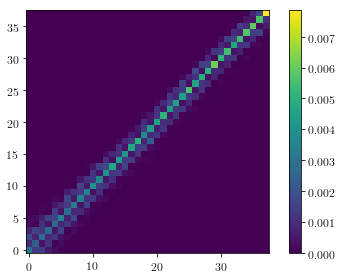

In [14]:
plt.imshow(response, origin='lower')
plt.colorbar()
plt.show()

In [15]:
print('Loading data into memory...')
df_data = comp.load_data(config=config,
                         energy_reco=False,
                         log_energy_min=None,
                         log_energy_max=None,
                         columns=feature_list + ['lap_ra', 'lap_dec'],
                         n_jobs=15,
                         verbose=True)

Loading data into memory...
[########################################] | 100% Completed |  2min 47.4s


### Data declination distribution

In [16]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [17]:
dec_median = df_data.loc[:, 'lap_dec'].median()
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.31664469968 [rad]
dec_median = -75.4381844099 [deg]


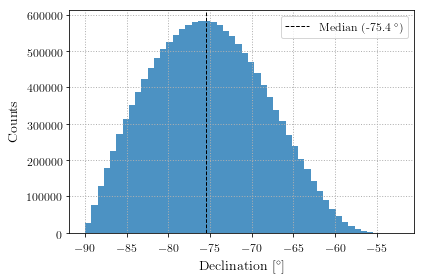

In [18]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

### Flux vs. declination 

In [19]:
import dask.array as da

X_data = da.from_array(df_data[feature_list].values, chunks=int(1e4))
X_data

dask.array<array, shape=(14790043, 3), dtype=float64, chunksize=(10000, 3)>

In [20]:
from dask_ml.wrappers import ParallelPostFit
from dask.diagnostics import ProgressBar

pred_comp_target = ParallelPostFit(comp_pipeline).predict(X_data)
reco_log_energy = ParallelPostFit(energy_pipeline).predict(X_data)

In [21]:
with ProgressBar():
    print('Running energy reconstructions...')
    df_data['reco_log_energy'] = reco_log_energy.compute(schuduler='threads', 
                                                         num_workers=20)
    print('Running composition classifications...')
    df_data['pred_comp_target'] = pred_comp_target.compute(schuduler='threads', 
                                                           num_workers=20)

Running energy reconstructions...
[########################################] | 100% Completed |  1min 43.7s
Running composition classifications...
[                                        ] | 2% Completed |  0.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#                                       ] | 4% Completed |  0.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##                                      ] | 6% Completed |  0.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##                                      ] | 7% Completed |  1.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####                                    ] | 10% Completed |  1.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####                                   ] | 12% Completed |  1.5s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####                                   ] | 14% Completed |  1.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[######                                  ] | 16% Completed |  1.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#######                                 ] | 18% Completed |  2.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[########                                ] | 20% Completed |  2.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#########                               ] | 22% Completed |  2.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#########                               ] | 24% Completed |  2.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##########                              ] | 26% Completed |  3.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###########                             ] | 28% Completed |  3.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[############                            ] | 30% Completed |  3.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[############                            ] | 32% Completed |  3.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#############                           ] | 34% Completed |  3.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##############                          ] | 36% Completed |  4.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###############                         ] | 38% Completed |  4.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[################                        ] | 40% Completed |  4.5s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[################                        ] | 42% Completed |  4.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#################                       ] | 43% Completed |  4.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##################                      ] | 46% Completed |  5.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################                     ] | 47% Completed |  5.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################                     ] | 48% Completed |  5.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####################                    ] | 52% Completed |  5.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####################                   ] | 54% Completed |  5.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[######################                  ] | 56% Completed |  6.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#######################                 ] | 58% Completed |  6.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[########################                ] | 60% Completed |  6.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#########################               ] | 63% Completed |  6.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##########################              ] | 65% Completed |  7.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##########################              ] | 67% Completed |  7.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###########################             ] | 69% Completed |  7.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[############################            ] | 71% Completed |  7.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#############################           ] | 73% Completed |  7.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##############################          ] | 75% Completed |  8.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##############################          ] | 77% Completed |  8.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###############################         ] | 79% Completed |  8.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[################################        ] | 81% Completed |  8.6s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#################################       ] | 83% Completed |  8.8s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[##################################      ] | 85% Completed |  9.0s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################################     ] | 87% Completed |  9.2s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[###################################     ] | 89% Completed |  9.4s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####################################    ] | 92% Completed |  9.7s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[#####################################   ] | 94% Completed |  9.9s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[######################################  ] | 96% Completed | 10.1s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[####################################### ] | 98% Completed | 10.3s

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python

[########################################] | 100% Completed | 10.4s


/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
# print('Running energy and composition reconstructions...')
# df_data['pred_comp_target'] = comp_pipeline.predict(df_data[feature_list].values)
# df_data['reco_log_energy'] = energy_pipeline.predict(df_data[feature_list].values)

In [23]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area
    
# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [24]:
np.rad2deg(np.arccos(df_data.lap_cos_zenith.max())), np.rad2deg(np.arccos(df_data.lap_cos_zenith.min()))

(0.0048982721856552, 37.65427444520522)

In [25]:
def calc_solid_angle(theta_min=0, theta_max=np.pi/2):
    return 2*np.pi*(np.cos(theta_min) - np.cos(theta_max))

def calc_geom_factor(theta_min=0, theta_max=np.pi/2):
    return (np.cos(theta_min) + np.cos(theta_max)) / 2

In [26]:
efficiencies

array([0.00711839, 0.0063939 , 0.00792342, 0.00747082, 0.00837221,
       0.0080099 , 0.008605  , 0.00827364, 0.0087326 , 0.00842248,
       0.00880584, 0.00853154, 0.00885625, 0.00862469, 0.00889662,
       0.00870939, 0.0089316 , 0.00879194, 0.00896487, 0.00887237,
       0.00899603, 0.00895298, 0.00902592, 0.00903645, 0.00905475,
       0.00911802, 0.00908371, 0.00919968, 0.00911568, 0.00928121,
       0.00914495, 0.00936215, 0.00917547, 0.00944462, 0.00920386,
       0.00952653, 0.00923482, 0.00960895])

light
heavy


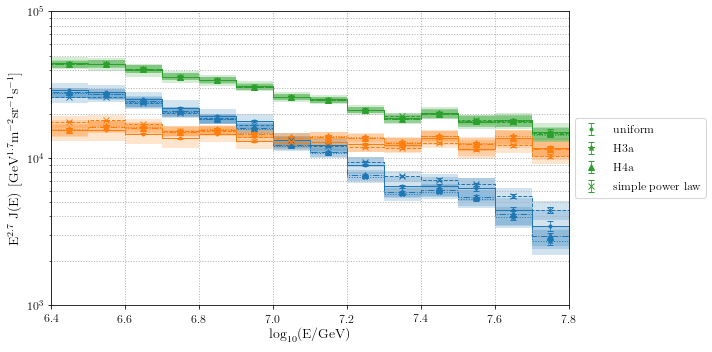

In [82]:
filenames = ['allsky.png']
# filenames = ['dec_lt_median.png', 'dec_gt_median.png', 'allsky.png']
theta_lims = [(0, 90)]

for filename, (theta_min, theta_max) in zip(filenames, theta_lims):

    # Solid angle
#     theta_max = 40 if config == 'IC79.2010' else 65
    solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2
#     solid_angle = calc_solid_angle(theta_min=theta_min, theta_max=theta_max)
    geom_factor = calc_geom_factor(theta_min=theta_min, theta_max=theta_max)
    geom_factor = 1

    def counts_to_flux(counts, counts_err=None, composition=None):
        return comp.get_flux(counts, counts_err,
                             energybins=energybins.energy_bins,
                             eff_area=thrown_area,
                             eff_area_err=None,                            
#                              eff_area=geom_factor * eff_area[composition],
#                              eff_area_err=geom_factor * eff_area_err[composition],
                             livetime=livetime,
                             livetime_err=livetime_err,
                             solid_angle=solid_angle,
                             scalingindex=2.7)


    counts_observed = {}
    counts_observed_err = {}

#     dec_mask = df_data['lap_dec'] < dec_median
    dec_mask = np.ones(df_data.shape[0], dtype=bool)

    for idx, composition in enumerate(comp_list):
        print(composition)
        # Filter out events that don't pass composition & energy mask
        pred_comp_mask = df_data['pred_comp_target'] == idx

        mask = np.logical_and(pred_comp_mask, dec_mask)
    #     df_data = df_data.loc[df_data, :]
    #     print(mask)
    #     print(pred_comp_mask.sum())

        energies = df_data.loc[mask, 'reco_log_energy'].values
        comp_counts, _ = np.histogram(energies,
                                      bins=energybins.log_energy_bins)
        counts_observed[composition] = comp_counts
        counts_observed_err[composition] = np.sqrt(comp_counts)

    counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
    # Calculate total counts
    counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

    # Format observed counts, detection efficiencies, and priors for PyUnfold use
    counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    for idx, composition in enumerate(comp_list):
        counts_pyunfold[idx::num_groups] = counts_observed[composition]
        counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]


    # Run unfolding for each of the priors
    names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
    # names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
    unfolding_results = {}
    for prior_name in names:
        prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
        # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
        df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                      data_err=counts_err_pyunfold,
                                                      response=response,
                                                      response_err=response_err,
                                                      efficiencies=efficiencies,
                                                      efficiencies_err=efficiencies_err,
                                                      ts='ks',
                                                      ts_stopping=0.005,
                                                      prior=prior,
                                                      return_iterations=True)
    #                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=3, smooth=1)])
        unfolding_results[prior_name] = df_unfolding_iter



    fig, ax = plt.subplots(figsize=(10, 5))
    linestyles = ['-', ':', '-.', '--']
    markers = ['.', '*', '^', 'x']
    for prior_name, ls, marker in zip(names, linestyles, markers):
        counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                            num_groups=num_groups)
        for composition in comp_list + ['total']:
            flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                                counts_err=counts_sys_err[composition],
                                                composition=composition)
            flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                                 counts_err=counts_stat_err[composition],
                                                 composition=composition)
            comp.plot_steps(energybins.log_energy_bins, 
                            flux,
                            yerr=flux_sys_err,
                            color=color_dict[composition],
                            ls=ls,
                            ax=ax)
            label = prior_name.replace('_', ' ') if composition == 'total' else ''
            ax.errorbar(energybins.log_energy_midpoints, flux,
                        yerr=flux_stat_err,
                        color=color_dict[composition],
                        ls='None',
                        marker=marker,
                        label=label)
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e3, 1e5)
    ax.grid(lw=1, which='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
    outfile = os.path.join(comp.paths.figures_dir, 'skymaps', filename)
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_lt_median.png')
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_gt_median.png')
    comp.check_output_dir(outfile)
#     plt.savefig(outfile)
    plt.show()

## Cosmic-ray flux vs. sky position

In [34]:
nside = 64
npix = hp.nside2npix(nside)

In [35]:
def equatorial_to_healpy(ra, dec):
    """Converts equatorial coordinates (ra, dec) to healpy coordinates (theta, phi)
    
    Parameters
    ----------
    ra : float, array_like
        Right ascension coordinates in radians. 
    dec : float, array_like
        Declination coordinates in radians. 
    
    Returns
    -------
    theta : float, array_like
        Healpy theta coordinates in radians.
    phi : float, array_like
        Healpy phi coodinates in radians.
    """
    theta = np.pi/2 - dec
    phi = ra

    return theta, phi


def healpy_to_equatorial(theta, phi):
    """Converts healpy coordinates (theta, phi) to equatorial coordinates (ra, dec)
    
    Parameters
    ----------
    theta : float, array_like
        Healpy theta coordinates in radians.
    phi : float, array_like
        Healpy phi coodinates in radians.
    
    Returns
    -------
    ra : float, array_like
        Right ascension coordinates in radians. 
    dec : float, array_like
        Declination coordinates in radians. 
    """
    dec = np.pi/2 - theta
    ra = phi

    return ra, dec

In [36]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values
# Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in healpy
theta, phi = comp.equatorial_to_healpy(ra, dec)

In [37]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


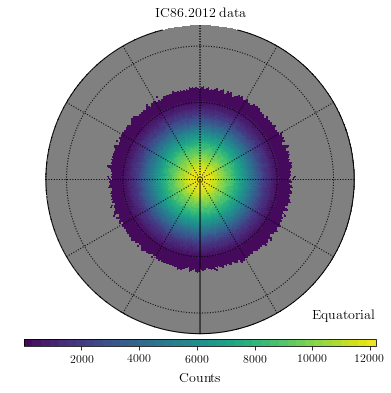

In [38]:
data_skymap[data_skymap == 0] = hp.UNSEEN
comp.plot_skymap(data_skymap, cbar_title='Counts', polar=True)
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-data-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [90]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [106]:
ra_test = np.deg2rad(72)
dec_test = np.deg2rad(-88)

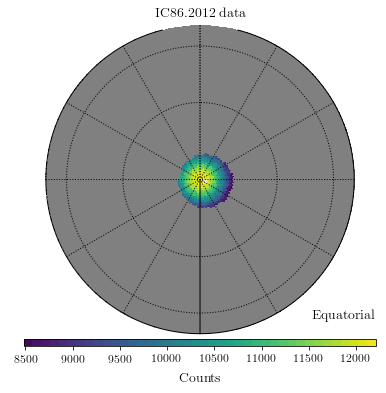

In [107]:
theta_test, phi_test = equatorial_to_healpy(ra_test, dec_test)
vec = hp.ang2vec(theta_test, phi_test)
radius = np.deg2rad(10)
ipix = hp.query_disc(nside, vec=vec, radius=radius)
in_disc = np.isin(np.arange(npix), ipix)
on_disc_skymap = data_skymap.copy()
on_disc_skymap[~in_disc] = hp.UNSEEN

on_disc_skymap[on_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(on_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-on-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

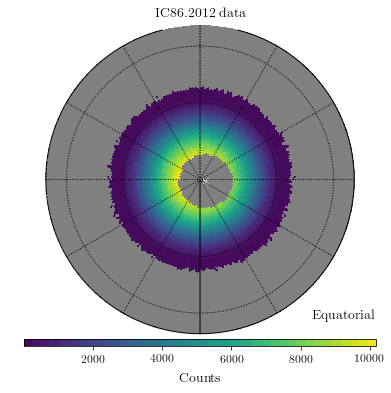

In [108]:
off_disc_skymap = data_skymap.copy()
off_disc_skymap[in_disc] = hp.UNSEEN

off_disc_skymap[off_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(off_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-off-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [109]:
theta, phi = equatorial_to_healpy(df_data.loc[:, 'lap_ra'].values,
                                  df_data.loc[:, 'lap_dec'].values)
pix_idx = hp.ang2pix(nside=nside, theta=theta, phi=phi)
in_disc = np.isin(pix_idx, ipix)

energies_in_disc = df_data.loc[in_disc, 'reco_log_energy'].values
counts_in_disc, _ = np.histogram(energies_in_disc, bins=np.arange(6.4, 7.9, 0.1)) 

energies_outside_disc = df_data.loc[~in_disc, 'reco_log_energy'].values
counts_outside_disc, _ = np.histogram(energies_outside_disc, bins=np.arange(6.4, 7.9, 0.1))

test_chi2 = calc_chi_squared(counts_in_disc, counts_outside_disc)
print('test_chi2 = {}'.format(test_chi2))

test_chi2 = 343.927342909


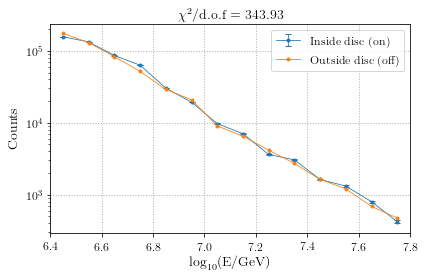

In [110]:
in_energy_range = np.logical_and(energybins.log_energy_midpoints <= 7.8,
                                 energybins.log_energy_midpoints >= 6.4)

fig, ax = plt.subplots()
ax.errorbar(energybins.log_energy_midpoints[in_energy_range], counts_in_disc,
            yerr=np.sqrt(counts_in_disc),
            label='Inside disc (on)')
alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
expected = alpha * counts_outside_disc
ax.errorbar(energybins.log_energy_midpoints[in_energy_range], expected,
#             yerr=np.sqrt(expected),
            label='Outside disc (off)')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('Counts')
ax.set_title('$\mathrm{\\chi^2 / d.o.f} = $ '+'{:0.2f}'.format(test_chi2))
ax.set_xlim(6.4, 7.8)
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-energy-dist-comparison.png'.format(config))
plt.savefig(outfile)
plt.show()

In [105]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [87]:
def disc_chi_squared(data, ra_disc, dec_disc, radius=np.deg2rad(10),
                     nside=64, energy_bins=None):
    """Calculates energy spectrum chi-squared for a disc on the sky
    
    Parameters
    ----------
    data : pandas.DataFrame
        Input data set.
    ra_disc : float
        Right ascension (in radians) of disc on sky. 
    dec_disc : float
        Declination (in radians) of disc on sky.
    radius : float, optional
        Radius (in radians) of disc on sky (default is 0.17 radians, 
        or 10 degrees).
    nside : float, optional
        Number of sides (default is 64).
    energy_bins : array_like, optional
        Energy bin edges to use when making binned energy 
        disbtritutions (default is numpy.arange(6, 8.1, 0.1)).
        
    Returns
    -------
    chi_squared : float
        Reduced chi-squared between the energy distributions inside and 
        outside the disc. 
    """ 
    # Input validation 
    if not isinstance(data, pd.DataFrame):
        raise TypeError('data must be a pandas DataFrame')
        
    columns = ['lap_ra', 'lap_dec', 'reco_log_energy']
    if not all([col in data.columns for col in columns]):
        raise ValueError('data must have columns {}'.format(columns))
    
    theta_disc, phi_disc = equatorial_to_healpy(ra_disc, dec_disc)
    vec_disc = hp.ang2vec(theta_disc, phi_disc)
    ipix = hp.query_disc(nside=nside, vec=vec_disc, radius=radius)
    
    theta, phi = equatorial_to_healpy(data.loc[:, 'lap_ra'].values,
                                      data.loc[:, 'lap_dec'].values)
    pix_idx_data = hp.ang2pix(nside=nside, theta=theta, phi=phi)
    
    in_disc = np.isin(pix_idx_data, ipix)    
    if not np.sum(in_disc):
        raise ValueError('No data events in disc at '
                         'ra={}, dec={}, radius={}'.format(ra_disc, dec_disc, radius))
    
    # Energy distribution inside and outside of disc
    if energy_bins is None:
        energy_bins = np.arange(6, 8.1, 0.1)
        
    energies_in_disc = data.loc[in_disc, 'reco_log_energy'].values
    counts_in_disc, _ = np.histogram(energies_in_disc, bins=energy_bins) 
    
    energies_outside_disc = data.loc[~in_disc, 'reco_log_energy'].values
    counts_outside_disc, _ = np.histogram(energies_outside_disc, bins=energy_bins) 

    return calc_chi_squared(counts_in_disc, counts_outside_disc)


def calc_chi_squared(counts_on, counts_off):
    """Calculates reduced chi-squared between two energy histograms
    
    Parameters
    ----------
    counts_on : numpy.ndarray
        Energy distribution inside disc. 
    counts_off : numpy.ndarray
        Energy distribution outside disc. 
        
    Returns
    -------
    chi_squared : float
        Reduced chi-squared between two input distributions. 
    """
    assert counts_on.shape == counts_off.shape
    alpha = np.sum(counts_on) / np.sum(counts_off)    
    expected = alpha * counts_off
    chi2 = (counts_on - expected)**2 / counts_on
    return np.nanmean(chi2)

In [73]:
%lprun -f disc_chi_squared disc_chi_squared(data=df_data, ra_disc=np.deg2rad(72), dec_disc=np.deg2rad(-72), radius=np.deg2rad(10))

Timer unit: 1e-06 s

Total time: 7.24978 s
File: <ipython-input-70-3de6bc1f9ecd>
Function: disc_chi_squared at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def disc_chi_squared(data, ra_disc, dec_disc, radius=np.deg2rad(10),
     2                                                                nside=64, energy_bins=None):
     3                                               """Calculates energy spectrum chi-squared for a disc on the sky
     4                                               
     5                                               Parameters
     6                                               ----------
     7                                               data : pandas.DataFrame
     8                                                   Input data set.
     9                                               ra_disc : float
    10                                                   Right ascension (in radian

In [57]:
theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
# has_data = dec < df_data.loc[:, 'lap_dec'].max()
has_data = dec < np.deg2rad(-60)
# has_data = dec < np.deg2rad(-70)
# has_data = dec < np.deg2rad(-80)
# has_data = dec < np.deg2rad(-85)
has_data.sum()

3280

In [58]:
chi2_delayed = []
pix_idxs = []
for theta_disc, phi_disc in zip(theta[has_data], phi[has_data]):
    ra_disc, dec_disc = healpy_to_equatorial(theta_disc, phi_disc)
#     print(ra_disc, dec_disc)
    radius = np.deg2rad(10)
    
    chi_squared = delayed(disc_chi_squared)(data=df_data,
                                            ra_disc=ra_disc,
                                            dec_disc=dec_disc,
                                            radius=radius,
                                            energy_bins=np.arange(6.4, 7.9, 0.1), 
#                                             energy_bins=energybins.log_energy_bins, 
                                            nside=nside)
    chi2_delayed.append(chi_squared)

    theta_disc, phi_disc = comp.equatorial_to_healpy(ra_disc, dec_disc)
    pix_idx = hp.ang2pix(nside, theta_disc, phi_disc)
    pix_idxs.append(pix_idx)

In [59]:
len(chi2_delayed)

3280

In [60]:
with ProgressBar(dt=5):
    chi2 = compute(*chi2_delayed, scheduler='threads', num_workers=25)
    chi2 = np.asarray(chi2)

[########################################] | 100% Completed |  1hr 22min 48.9s


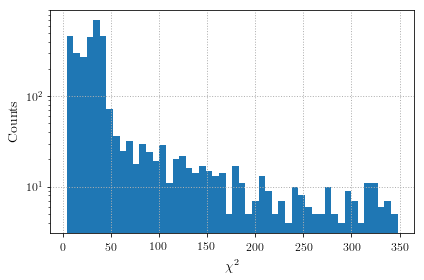

In [63]:
fig, ax = plt.subplots()
ax.hist(chi2, bins=50)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\\chi^2$')
ax.set_ylabel('Counts')
ax.grid()
plt.show()

In [74]:
chi2_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
chi2_map[pix_idxs] = chi2

Save map to disk

In [75]:
hp.write_map('chi-squared-map.fits', chi2_map, dtype=chi2_map.dtype, coord='C')

In [76]:
chi2_map = hp.read_map('chi-squared-map.fits')

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


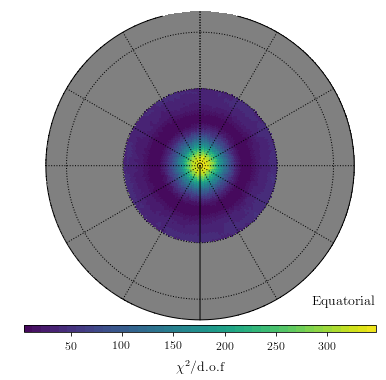

In [78]:
# chi2_map[chi2_map == 0] = hp.UNSEEN
# chi2_map = np.full(npix, hp.UNSEEN)
comp.plot_skymap(chi2_map, cbar_title='$\mathrm{\chi^2 / d.o.f}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-chi2-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [87]:
energy_mask = df_data.loc[:, 'reco_log_energy'] > 7.9
energy = df_data.loc[energy_mask, 'reco_log_energy']
ra = df_data.loc[energy_mask, 'lap_ra']
dec = df_data.loc[energy_mask, 'lap_dec']

theta, phi = equatorial_to_healpy(ra, dec)

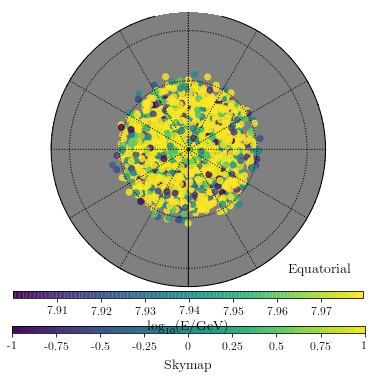

In [103]:
comp.plot_skymap(np.full(npix, hp.UNSEEN), polar=True)
fig = plt.gcf()
ax = plt.gca()

image = hp.projscatter(theta, phi, c=energy, alpha=0.8)
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
plt.show()

In [75]:
theta, phi = hp.pix2ang(nside, range(npix))
dec = np.pi/2 - theta
has_data = np.rad2deg(dec) < -80
has_data.sum()

364

In [76]:
num_samples = npix
# theta_grid, phi_grid = hp.pix2ang(nside, range(num_samples))
# ra_grid = phi_grid
# dec_grid = np.pi/2 - theta_grid

theta, phi = hp.pix2ang(nside, range(npix))
dec = np.pi/2 - theta
has_data = np.rad2deg(dec) < -80

vecs = hp.pix2vec(nside, range(num_samples))
x, y, z = vecs
radius = np.deg2rad(5)

chi2_map = np.zeros(npix)
chi2_delayed = []
# for vec in vecs:
for x_vec, y_vec, z_vec in zip(x[has_data],
                               y[has_data],
                               z[has_data]):
# for pix_idx, (ra_disc, dec_disc) in enumerate(zip(ra_grid, dec_grid)):
    chi_squared = delayed(calc_chi2)(data=df_data,
#                                      ra_disc=ra_disc,
#                                      dec_disc=dec_disc,
                                     vec_disc=(x_vec, y_vec, z_vec), 
                                     radius=radius)
    chi2_delayed.append(chi_squared)

In [77]:
with ProgressBar():
    chi2 = compute(*chi2_delayed, scheduler='multiprocess', num_workers=20)
    chi2 = np.asarray(chi2)

[########################################] | 100% Completed |  7min 11.0s


In [79]:
chi2.shape

(364,)

In [80]:
chi2_map = np.zeros(npix)
chi2_map[has_data] = chi2
# for pix_idx, c in enumerate(chi2):
#     chi2_map[pix_idx] = c

In [81]:
chi2_map

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.22903789e-05, 4.18436853e-05, 4.13990575e-05])

In [ ]:
# for i in range(ra_grid.shape[0]):
#     for j in range(dec_grid.shape[0]):
#         ra_disc = np.deg2rad(rav[j, i])
#         dec_disc = np.deg2rad(decv[j, i])
#         radius = np.deg2rad(10)
#         theta, phi = comp.equatorial_to_healpy(ra_disc, dec_disc)
#         pix_idx = hp.ang2pix(nside, theta, phi)
#         chi2_map[pix_idx] = chi_squared

In [82]:
np.sum(chi2_map != 0)

364

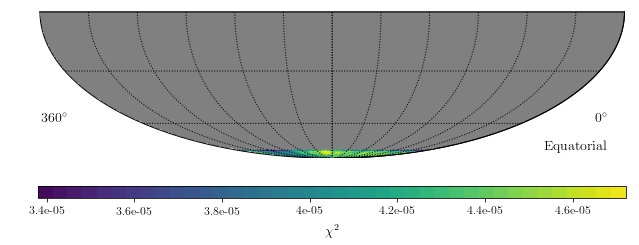

In [85]:
chi2_map[chi2_map == 0] = hp.UNSEEN
comp.plot_skymap(chi2_map, cbar_title='$\chi^2$')
plt.show()

/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/data/user/jbourbeau/virtualenv/cr-composition_el7/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


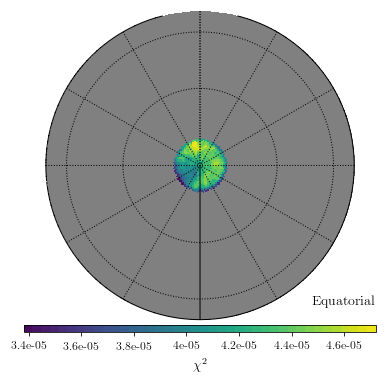

In [86]:
comp.plot_skymap(chi2_map, cbar_title='$\chi^2$', polar=True)
plt.show()

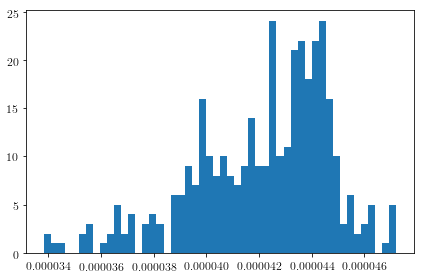

In [88]:
plt.hist(chi2, bins=50)
plt.show()

chi_squared = 4.56955729074e-05
chi_squared = 0.000314023466112
chi_squared = 0.000571068201967
chi_squared = 0.000284044372403
chi_squared = 0.000112751246773
chi_squared = 0.000152905875611
chi_squared = 0.000113949906513
chi_squared = 0.000158659203443
chi_squared = 0.000374920081321
chi_squared = 0.000763270407629


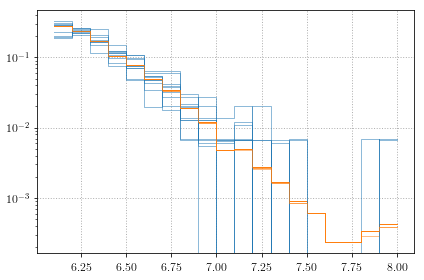

In [64]:
fig, ax = plt.subplots()

ra_grid = np.linspace(0, 360, 10)
dec_grid = np.linspace(-40,-90, 10)
for ra_deg, dec_deg in zip(ra_grid, dec_grid):
    ra_disc = np.deg2rad(ra_deg)
    dec_disc = np.deg2rad(dec_deg)
    radius = np.deg2rad(10)
    counts_on, counts_off = calc_chi2(data=df_data,
                                      ra_disc=ra_disc,
                                      dec_disc=dec_disc,
                                      radius=radius)
    comp.plot_steps(energybins.log_energy_bins, counts_on, color='C0', alpha=0.5, label='ON')
    comp.plot_steps(energybins.log_energy_bins, counts_off, color='C1', alpha=0.5, label='OFF')
    
#     ax.plot(counts_on, color='C0', alpha=0.5, label='ON')
#     ax.plot(counts_off, color='C1', alpha=0.5, label='OFF')
ax.set_yscale('log', nonposy='clip')
ax.grid()
# ax.legend()
plt.show()

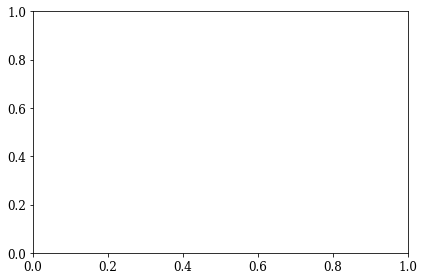

In [86]:
# fig, ax = plt.subplots()
hp.projscatter(theta[:10], phi[:10], rot=180)
hp.graticule(verbose=False)
# fig = plt.gcf()
# ax = plt.gca()
# image = ax.get_images()[0]
# cbar = fig.colorbar(image,
#                     orientation='horizontal',
#                     aspect=50,
#                     pad=0.01,
#                     fraction=0.1,
#                     ax=ax,
#                     format=FormatStrFormatter('%g'),
#                     shrink=1.0)
# plt.show()

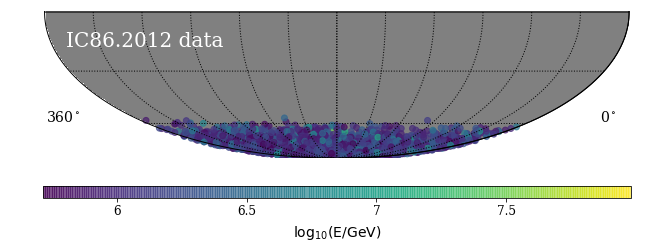

In [115]:
# pix_idx = df_data.iloc[:2]['pix_idx'].values
reco_log_energy = df_data['reco_log_energy'].values

m = np.full(npix, hp.UNSEEN)
hp.mollview(m, rot=180, title='', cbar=False)
hp.graticule(verbose=False)

fig = plt.gcf()
ax = plt.gca()

num_samples = 2000
image = hp.projscatter(theta[:num_samples], phi[:num_samples],
                       c=reco_log_energy[:num_samples],
                       alpha=0.7)

# image = ax.get_images()[0]
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
ax.set_ylim(-1, 0.005)
ax.annotate('0$^\circ$', xy=(1.8, -0.75), size=14)
ax.annotate('360$^\circ$', xy=(-1.99, -0.75), size=14)
ax.annotate('IC86.2012 data', xy=(-1.85,-0.24), size=20, color='white')
plt.show()

In [302]:
dec.min(), dec.max()

(-1.5706758358557722, -0.9144460118811598)

In [62]:
dec_median = np.median(dec)
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.31664469968 [rad]
dec_median = -75.4381844099 [deg]


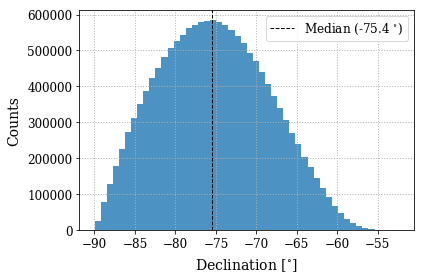

In [63]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()